In [1]:
import matplotlib.pyplot as plt
import anndata as ad 
import torch
import pandas as pd
import json
import numpy as np

from importlib import reload
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster

from matplotlib.colors import ListedColormap

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

# drop blanks and controls
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

In [9]:
dataset_name = "hBreast"
models = ["Leiden", "Louvain", "K-Means", "K-Means_No_Spatial", "Hierarchical", "Hierarchical_No_Spatial", "BayesSpace"]
spot_sizes = [50, 75, 100]
K_values = [17]
resolutions = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

In [10]:
def get_leaf_values(d):
    if isinstance(d, dict):
        for v in d.values():
            yield from get_leaf_values(v)
    elif isinstance(d, list):
        yield d
    else:
        yield d

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


The size of the spot data is (23444, 280)


/tmp/ipykernel_1055015/3088359593.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(clustering.xenium_spot_data.obs["row"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(clustering.xenium_spot_data.obs["col"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(cluster

The size of the spot data is (10734, 280)


/tmp/ipykernel_1055015/3088359593.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(clustering.xenium_spot_data.obs["row"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(clustering.xenium_spot_data.obs["col"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(cluster

The size of the spot data is (6138, 280)


/tmp/ipykernel_1055015/3088359593.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(clustering.xenium_spot_data.obs["row"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(clustering.xenium_spot_data.obs["col"].astype(int))
/tmp/ipykernel_1055015/3088359593.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(cluster

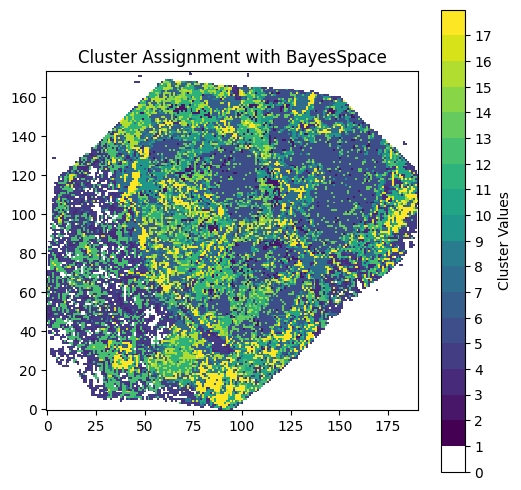

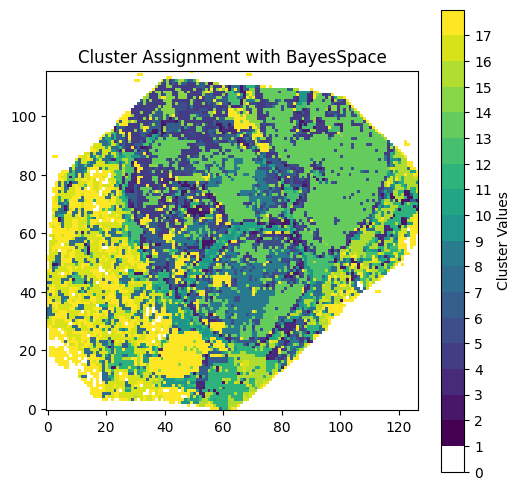

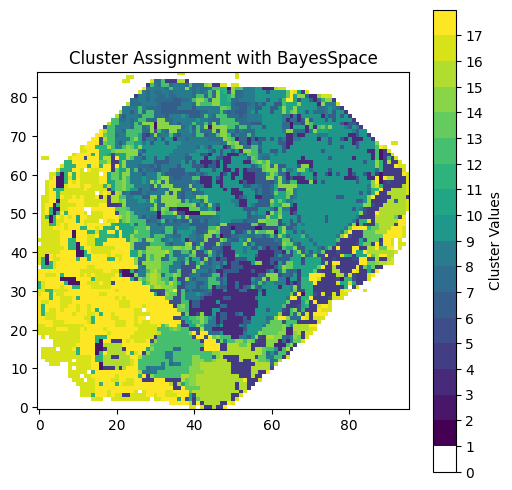

In [11]:
for spot_size in spot_sizes:   
    clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)

    print(f"The size of the spot data is {clustering.xenium_spot_data.shape}")

    clustering.normalize_counts(clustering.xenium_spot_data)
    clustering.generate_neighborhood_graph(clustering.xenium_spot_data, plot_pcas=False) 
    for model_name in models:
        for K in K_values:
            if model_name in ["Leiden", "Louvain"]:
                for resolution in resolutions:
                    target_dir = f"results/{dataset_name}/{model_name}/{resolution}/clusters/{spot_size}"
                    
                    cluster_labels = pd.read_csv(f"{target_dir}/clusters_RES={resolution}.csv")[f"{model_name} cluster"]
                    clustering.xenium_spot_data.obs["cluster"] = np.array(cluster_labels)
                    # Extracting row, col, and cluster values from the dataframe
                    rows = torch.tensor(clustering.xenium_spot_data.obs["row"].astype(int))
                    cols = torch.tensor(clustering.xenium_spot_data.obs["col"].astype(int))
                    clusters = torch.tensor(clustering.xenium_spot_data.obs["cluster"].astype(int))
                    num_clusters = len(np.unique(clusters))

                    num_rows = int(max(rows) - min(rows) + 1)
                    num_cols = int(max(cols) - min(cols) + 1)

                    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

                    cluster_grid[rows, cols] = torch.tensor(clusters, dtype=torch.int) + 1

                    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
                    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
                    colormap = ListedColormap(colormap_colors)

                    plt.figure(figsize=(6, 6))
                    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
                    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
                    plt.title(f'Cluster Assignment with {model_name}')

                    plt.savefig(
                        f"{target_dir}/clusters_RES={resolution}.png"
                    )
            else:
                target_dir = f"results/{dataset_name}/{model_name}/{K}/clusters/{spot_size}"
                
                cluster_labels = pd.read_csv(f"{target_dir}/clusters_K={K}.csv")[f"{model_name} cluster"]
                clustering.xenium_spot_data.obs["cluster"] = np.array(cluster_labels)
                clustering.xenium_spot_data.obs["cluster"] = np.array(cluster_labels)
                # Extracting row, col, and cluster values from the dataframe
                rows = torch.tensor(clustering.xenium_spot_data.obs["row"].astype(int))
                cols = torch.tensor(clustering.xenium_spot_data.obs["col"].astype(int))
                clusters = torch.tensor(clustering.xenium_spot_data.obs["cluster"].astype(int))
                num_clusters = len(np.unique(clusters))

                num_rows = int(max(rows) - min(rows) + 1)
                num_cols = int(max(cols) - min(cols) + 1)

                cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

                cluster_grid[rows, cols] = torch.tensor(clusters, dtype=torch.int) + 1

                colors = plt.cm.get_cmap('viridis', num_clusters + 1)
                colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
                colormap = ListedColormap(colormap_colors)

                plt.figure(figsize=(6, 6))
                plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
                plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
                plt.title(f'Cluster Assignment with {model_name.replace("_No_Spatial", "")}')

                plt.savefig(
                    f"{target_dir}/clusters_K={K}.png"
                )